# Introduction

The Ugrainium recipe uses groupings of ingredients to try to cover nutritional requirements with enough overlap that a single ingredient with quality issues does not cause a failure for the whole recipe. A opimizer is used to find the right amount of each ingredient to fulfill the nutritional and practicle requirements for a recipe.

# To Do

* Nutrients without an upper limit should have the upper limit constraint removed
* Add constraints for the NIH essential protein combinations as a limit
* Add a radar graph for vitamins showing the boundry between RDI and UL
* Add a radar graph for vitamins without an upper limit but showing the RDI
* Add a radar graph for essential proteins showing the range between RDI and UL
* Add a radar graph for essential proteins without an upper limit, but showing the RDI as the lower limit
* Add a radar graph pair for non-essential proteins with the above UL and no UL pairing
* Add equality constraints for at least energy, and macro nutrients if possible

In [1]:
# Import all of the helper libraries 

from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import least_squares
import pandas as pd
import numpy as np
import os
import json
from math import e
import matplotlib.pyplot as plt
import seaborn as sns
from math import log10
%matplotlib inline

In [2]:
#!pip install seaborn

In [3]:
# Setup the notebook context

data_dir = '../data'
pd.set_option('max_columns', 70)


# Our Data

The [tables](https://docs.google.com/spreadsheets/d/1UOx5ZkNMjcwybx9TgFS_EaQnjbokqDx6K9NW0mRDGlg/edit#gid=6244197120) containing our ingredients nutrition profile are held in Google Sheets.
The sheet names are "Ingredients" and "Nutrition Profile"


In [4]:
# Download our nutrition profile data from Google Sheets
!(cd ..; make sync_data_from_google)

nutrition_profile_df = pd.read_csv(f'{data_dir}/raw/nutrition_profile.csv', index_col=0, verbose=True).transpose()
ingredients_df = pd.read_csv(f'{data_dir}/raw/ingredients.csv', index_col=0, verbose=True).transpose()

# convert all values to float
for col in ingredients_df.columns:
    ingredients_df[col] = ingredients_df[col].astype(float)

curl 'https://docs.google.com/spreadsheets/d/1UOx5ZkNMjcwybx9TgFS_EaQnjbokqDx6K9NW0mRDGlg/export?format=csv&id=1UOx5ZkNMjcwybx9TgFS_EaQnjbokqDx6K9NW0mRDGlg&gid=624419712' > data/raw/nutrition_profile.csv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4196    0  4196    0     0   2767      0 --:--:--  0:00:01 --:--:--  2767
curl 'https://docs.google.com/spreadsheets/d/1UOx5ZkNMjcwybx9TgFS_EaQnjbokqDx6K9NW0mRDGlg/export?format=csv&id=1UOx5ZkNMjcwybx9TgFS_EaQnjbokqDx6K9NW0mRDGlg&gid=1812860789' > data/raw/ingredients.csv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4877    0  4877    0     0  12101      0 --:--:-- --:--:-- --:--:-- 12131
Tokenization took: 0.05 ms
Type conversion took: 1.68 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 0.12 ms
Typ

# Problem Setup

Let's cast our data into the from $\vec{y} = A \vec{x} + \vec{b}$ where $A$ is our ingredients data, $\vec{x}$ is the quantity of each ingredient for our recipe, and $\vec{b}$ is the nutrition profile.
The problem to be solved is to find the quantity of each ingredient which will optimally satisfy the nutrition profile, or in our model, to minimize: $|A \vec{x} - \vec{b}|$.

There are some nutrients we only want to track, but not optimize. For example, we want to know how much cholesterol is contained in our recipe, but we don't want to constrain our result to obtain a specific amount of cholesterol as a goal. The full list of ingredients are named: A_full, and b_full. The values to optimized are named: A and b

In [26]:
b_full = nutrition_profile_df
A_full = ingredients_df.transpose()
A = ingredients_df.transpose()[nutrition_profile_df.loc['Report Only'] == False]

b_full = nutrition_profile_df.loc['Target']
b = nutrition_profile_df.loc['Target'][nutrition_profile_df.loc['Report Only'] == False]
ul = nutrition_profile_df.loc['UL'][nutrition_profile_df.loc['Report Only'] == False]
rdi = nutrition_profile_df.loc['RDI'][nutrition_profile_df.loc['Report Only'] == False]
ul_full = nutrition_profile_df.loc['UL']
rdi_full = nutrition_profile_df.loc['RDI']

# Least Squares Optimization
Start with a simple solver using a least squares optimizer


In [27]:
# Using the scipy least_squares optimizer
# Define a residual function: if y = A x + b -> A x - b is the residual function
k_thres = 0.7
k_rdi = b - ((rdi - b) * k_thres)
k_ul =  b + ((ul - b) * k_thres)

def limit_scale(df):
    r = (df['y'] - df['b']) /  df['b']
    k_thres = 0.7
    if df['y'] < df['k_rdi']:
        r *= 10
        if df['y'] < df['rdi']:
            r *= 10
    elif df['y'] >= df['b']:
        if df['k_ul'] is np.NaN:
            return(0.0)
        elif df['y'] > df['k_ul']:
            r *= 10
        if df['y'] > df['ul']:
            r *= 10
    return(r)

scale_limits = pd.DataFrame({'rdi': rdi, 'k_rdi': k_rdi, 'b': b, 'k_ul': k_ul, 'ul': ul})

def residuals(x, *args, **kwargs):
    y0 = A.dot(x.transpose())
    res0 = pd.concat([scale_limits, pd.Series(y0,scale_limits.index, name='y')], axis=1)
    res1 = res0.apply(limit_scale, axis=1)
    return(res1)

In [28]:
# Constrain ingredients before the optimization process. Many of the ingredients are required for non-nutritional purposes 
# or are being limited to enhance flavor

bounds_df = pd.DataFrame(index=ingredients_df.index, data={'lower': 0, 'upper': np.inf})             
bounds_df.loc['Guar gum'] = [0.9 * .01, 0.9 * .01 + .0001]
bounds_df.loc['Xanthan Gum'] = [0.9 * .01, 0.9 * .01 + .0001]
bounds_df.loc['Alpha-galactosidase enzyme (Beano)'] = [1.0, 1.0 + .0001]
bounds_df.loc['Multivitamin'] = [1.0, 1.0 + .0001]
bounds_df.loc['Corn flour, nixtamalized'] = [0, 1.0]
bounds_df.loc['Whey protein'] = [0,0.15]
bounds_df.loc['Ascorbic acid'] = [0.01, 0.01 + .0001]
lower = list(bounds_df.lower.values)
upper = list(bounds_df.upper.values)

# x0 is our initial guess at a solution
x0 = np.array(lower)

len(lower), len(upper)

(20, 20)

In [29]:
solution = least_squares(residuals, x0, jac='2-point', bounds=(lower, upper), method='trf', ftol=1e-08, xtol=1e-08, gtol=1e-08, x_scale=1.0, loss='linear', f_scale=1.0, diff_step=None, tr_solver=None, tr_options={}, jac_sparsity=None, max_nfev=None, verbose=0, args=(), kwargs={})
solution.success, solution.x

(True, array([0.00906876, 0.33607804, 0.56299727, 0.00310732, 0.65874327,
        0.17196309, 1.        , 0.26720392, 0.43018112, 1.00002817,
        0.48332659, 0.46562733, 0.01      , 0.66838733, 0.09157498,
        0.03230391, 0.73440365, 0.00908047, 0.20858681, 0.59945334]))

In [9]:
A_full.dot(solution.x)

Calories (kcal)         1802.239257
Carbohydrates (g)        189.954684
Protein (g)              128.055228
Total Fat (g)             69.999999
Saturated Fat (g)         10.113780
                           ...     
Glutamic acid (mg)     24460.516042
Glycine (mg)            5408.777999
Proline (mg)            7143.411955
Serine (mg)             6327.709555
Hydroxyproline (mg)      183.658820
Length: 61, dtype: float64

In [10]:
# Scale the ingredient nutrient amounts for the given quantity of each ingredient given by the optimizer
solution_df = A_full.transpose().mul(solution.x, axis=0) # Scale each nutrient vector per ingredient by the amount of the ingredient
solution_df.insert(0, 'Quantity (g)', solution.x * 100) # Scale to 100 g since that is basis for the nutrient quantities

# Add a row showing the sum of the scaled amount of each nutrient
total = solution_df.sum()
total.name = 'Total'
solution_df = solution_df.append(total)
solution_df.transpose().index

Index(['Quantity (g)', 'Calories (kcal)', 'Carbohydrates (g)', 'Protein (g)',
       'Total Fat (g)', 'Saturated Fat (g)', 'Monounsaturated Fat (g)',
       'Polyunsaturated Fat (g)', 'Omega-3 Fatty Acids (g)',
       'Omega-6 Fatty Acids (g)', 'Total Fiber (g)', 'Soluble Fiber (g)',
       'Insoluble Fiber (g)', 'Cholesterol (mg)', 'Vitamin A (IU)',
       'Vitamin B6 (mg)', 'Vitamin B12 (ug)', 'Vitamin C (mg)',
       'Vitamin D (IU)', 'Vitamin E (IU)', 'Vitamin K (ug)', 'Thiamin (mg)',
       'Riboflavin (mg)', 'Niacin (mg)', 'Folate (ug)',
       'Pantothenic Acid (mg)', 'Biotin (ug)', 'Choline (mg)', 'Calcium (g)',
       'Chloride (g)', 'Chromium (ug)', 'Copper (mg)', 'Iodine (ug)',
       'Iron (mg)', 'Magnesium (mg)', 'Manganese (mg)', 'Molybdenum (ug)',
       'Phosphorus (g)', 'Potassium (g)', 'Selenium (ug)', 'Sodium (g)',
       'Sulfur (g)', 'Zinc (mg)', 'Cystine (mg)', 'Histidine (mg)',
       'Isoleucine (mg)', 'Leucine (mg)', 'Lysine (mg)', 'Methionine (mg)',
       'Ph

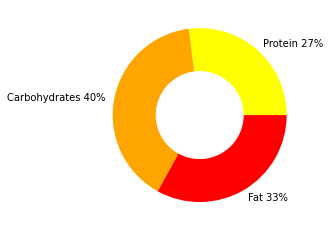

In [11]:
# Plot the macro nutrient profile
# The ratio of Calories for protein:carbohydrates:fat is 4:4:9 kcal/g
pc = solution_df['Protein (g)']['Total'] * 4.0
cc = solution_df['Carbohydrates (g)']['Total'] * 4.0
fc = solution_df['Total Fat (g)']['Total'] * 9.0
tc = pc + cc + fc
p_pct = int(round(pc / tc * 100))
c_pct = int(round(cc / tc * 100))
f_pct = int(round(fc / tc * 100))
(p_pct, c_pct, f_pct)
# create data
names=f'Protein {p_pct}%', f'Carbohydrates {c_pct}%', f'Fat {f_pct}%', 
size=[p_pct, c_pct, f_pct]
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.5, color='white')

# Give color names
plt.pie(size, labels=names, colors=['yellow','orange','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Also show the Fiber (soluble / insoluble ration) amount 
# Also show the Omega-3, Omega-6 ratio
# Saturated:Monounsaturated:Polyunsaturated ratios

In [35]:
# Prepare data as a whole for plotting by normalizing and scaling
amounts = solution_df
total = A_full.dot(solution.x) #solution_df.loc['Total']

# Normalize as a percent beyond RDI
#norm = (total - rdi) / rdi * 100
#norm_ul = (ul - rdi) / rdi * 100
norm = (total) / rdi_full
norm_ul = (ul_full) / rdi_full

nuts = pd.concat([pd.Series(norm.values, name='value'), pd.Series(norm.index, name='name')], axis=1)
total.index
norm.index

Index(['Calories (kcal)', 'Carbohydrates (g)', 'Protein (g)', 'Total Fat (g)',
       'Saturated Fat (g)', 'Monounsaturated Fat (g)',
       'Polyunsaturated Fat (g)', 'Omega-3 Fatty Acids (g)',
       'Omega-6 Fatty Acids (g)', 'Total Fiber (g)', 'Soluble Fiber (g)',
       'Insoluble Fiber (g)', 'Cholesterol (mg)', 'Vitamin A (IU)',
       'Vitamin B6 (mg)', 'Vitamin B12 (ug)', 'Vitamin C (mg)',
       'Vitamin D (IU)', 'Vitamin E (IU)', 'Vitamin K (ug)', 'Thiamin (mg)',
       'Riboflavin (mg)', 'Niacin (mg)', 'Folate (ug)',
       'Pantothenic Acid (mg)', 'Biotin (ug)', 'Choline (mg)', 'Calcium (g)',
       'Chloride (g)', 'Chromium (ug)', 'Copper (mg)', 'Iodine (ug)',
       'Iron (mg)', 'Magnesium (mg)', 'Manganese (mg)', 'Molybdenum (ug)',
       'Phosphorus (g)', 'Potassium (g)', 'Selenium (ug)', 'Sodium (g)',
       'Sulfur (g)', 'Zinc (mg)', 'Cystine (mg)', 'Histidine (mg)',
       'Isoleucine (mg)', 'Leucine (mg)', 'Lysine (mg)', 'Methionine (mg)',
       'Phenylalanine (mg)

In [38]:
# Setup categories of nutrients and a common plotting function
vitamins = ['Vitamin A (IU)','Vitamin B6 (mg)','Vitamin B12 (ug)','Vitamin C (mg)','Vitamin D (IU)',
            'Vitamin E (IU)','Vitamin K (ug)','Thiamin (mg)','Riboflavin (mg)','Niacin (mg)','Folate (ug)','Pantothenic Acid (mg)','Biotin (ug)','Choline (mg)']
minerals = ['Calcium (g)','Chloride (g)','Chromium (ug)','Copper (mg)','Iodine (ug)','Iron (mg)',
            'Magnesium (mg)','Manganese (mg)','Molybdenum (ug)','Phosphorus (g)','Potassium (g)','Selenium (ug)','Sodium (g)','Sulfur (g)','Zinc (mg)']
essential_aminoacids = ['Cystine (mg)','Histidine (mg)','Isoleucine (mg)','Leucine (mg)','Lysine (mg)',
                        'Methionine (mg)','Phenylalanine (mg)','Threonine (mg)','Tryptophan (mg)','Valine (mg)']
other_aminoacids = ['Tyrosine (mg)','Arginine (mg)','Alanine (mg)','Aspartic acid (mg)','Glutamic acid (mg)','Glycine (mg)','Proline (mg)','Serine (mg)','Hydroxyproline (mg)']

def plot_group(nut_names, title):
    nut_names_short = [s.split(' (')[0] for s in nut_names] # Snip off the units from the nutrient names
    
    # Create a bar to indicate an upper limit 
    ul_bar = (norm_ul * 1.04)[nut_names]
    ul_bar[ul_full[nut_names].isnull() == True] = 0
    
    # Create a bar to mask the UL bar so just the end is exposed
    ul_mask = norm_ul[nut_names]
    ul_mask[ul_full[nut_names].isnull() == True] = 0
    
    
    n = []  # normalized values for each bar
    for x, mx in zip(norm[nut_names], ul_mask.values):
        if mx == 0: # no upper limit
            if x < 1.0:
                n.append(1.0 - (x / 2.0))
            else:
                n.append(0.50)
        else:
            n.append(1.0 - (log10(x) / log10(mx)))
    clrs = sm.to_rgba(n, norm=False)
    
    g = sns.barplot(x=ul_bar.values, y=nut_names_short, color='red')
    g.set_xscale('log')
    sns.barplot(x=ul_mask.values, y=nut_names_short, color='white')
    bax = sns.barplot(x=norm[nut_names], y=nut_names_short, label="Total", palette=clrs)
    
    # Add a legend and informative axis label
    g.set( ylabel="",xlabel="Nutrient Mass / RDI (Red Band is UL)", title=title)

    #sns.despine(left=True, bottom=True)

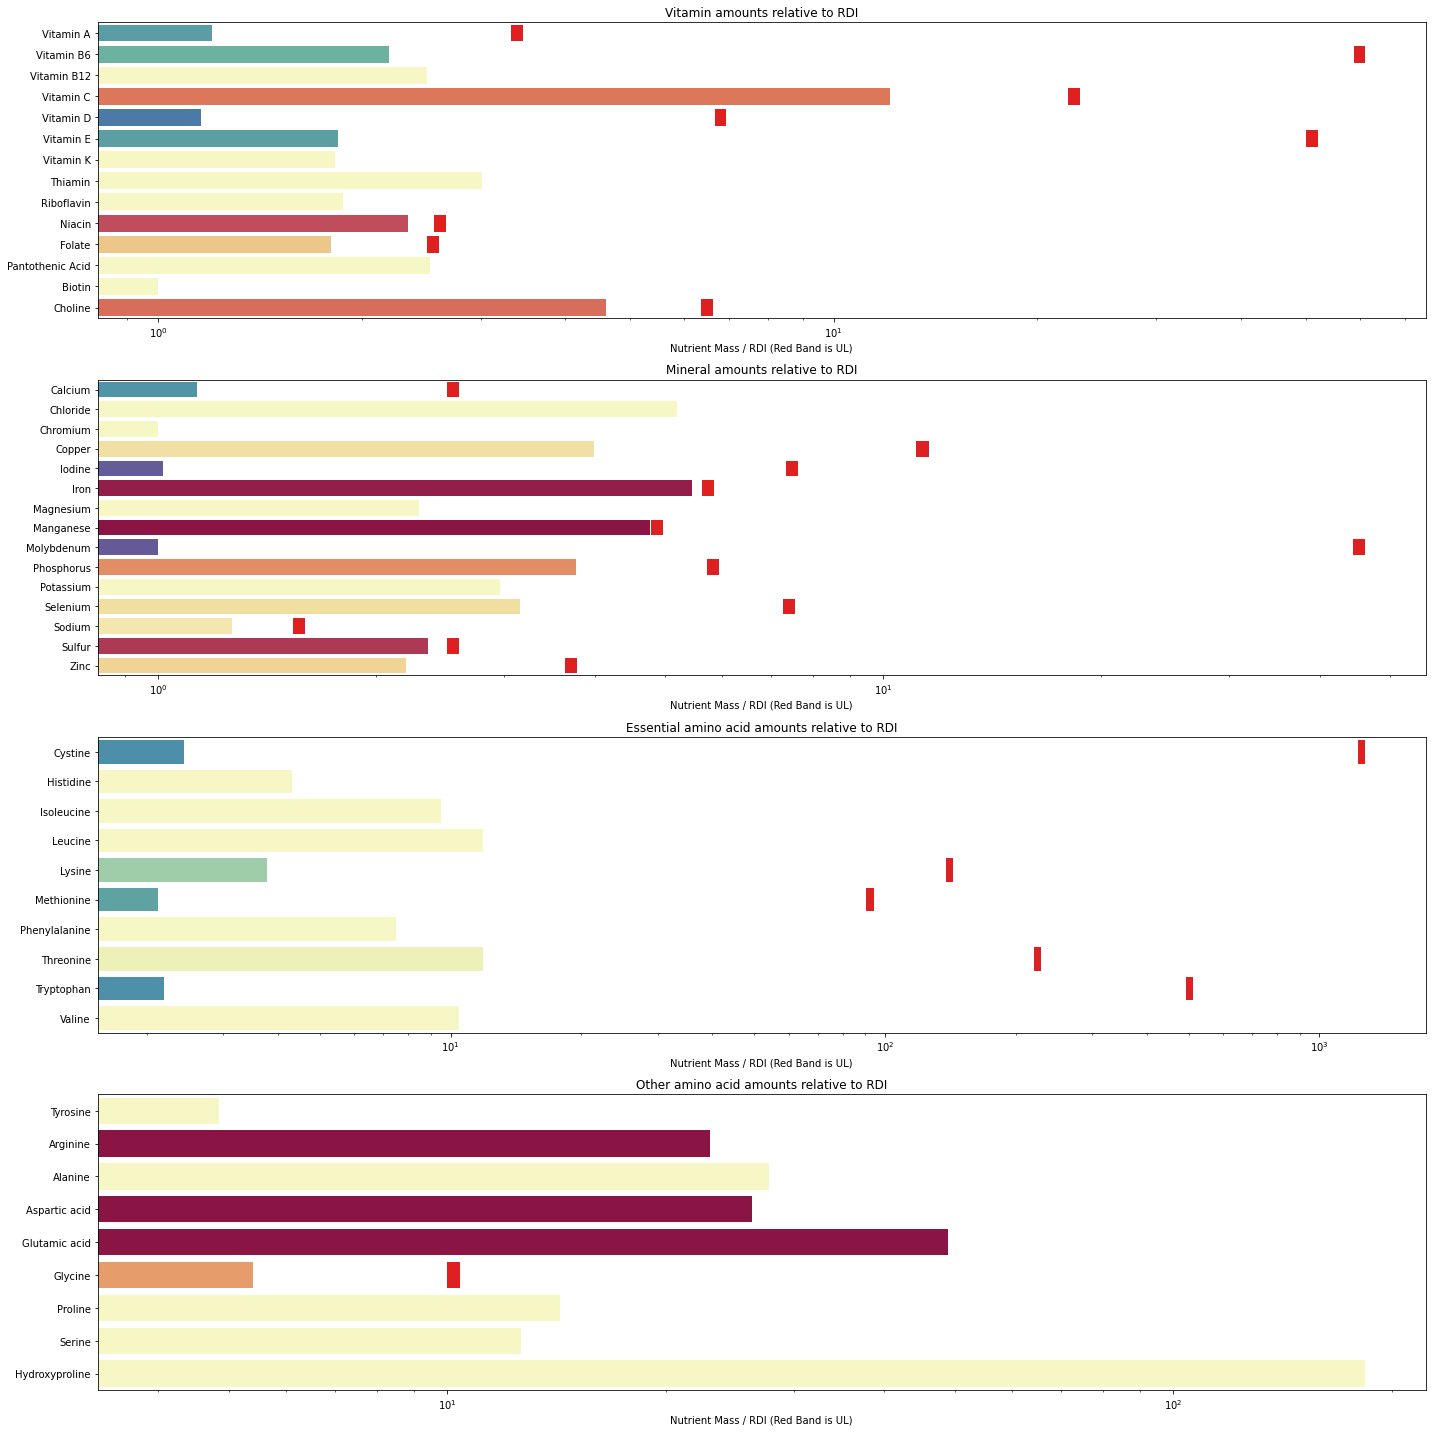

In [39]:
# Construct a group of bar charts for each nutrient group

# Setup the colormap for each bar
cmap = plt.get_cmap('Spectral')
sm = plt.cm.ScalarMappable(cmap=cmap)

#fig = plt.figure(figsize=plt.figaspect(3.))
fig = plt.figure(figsize=(20, 20))
fig.add_subplot(4, 1, 1)
plot_group(vitamins,'Vitamin amounts relative to RDI')
fig.add_subplot(4, 1, 2)
plot_group(minerals,'Mineral amounts relative to RDI')
fig.add_subplot(4, 1, 3)
plot_group(essential_aminoacids,'Essential amino acid amounts relative to RDI')
fig.add_subplot(4, 1, 4)
plot_group(other_aminoacids,'Other amino acid amounts relative to RDI')

#fig.show()
fig.tight_layout()

In [42]:
ul_full

Calories (kcal)        2000.1
Carbohydrates (g)         300
Protein (g)               300
Total Fat (g)              70
Saturated Fat (g)          22
                        ...  
Glutamic acid (mg)       3000
Glycine (mg)            10000
Proline (mg)              NaN
Serine (mg)               NaN
Hydroxyproline (mg)       NaN
Name: UL, Length: 61, dtype: object

In [41]:
rdi_full

Calories (kcal)        2000
Carbohydrates (g)       279
Protein (g)             104
Total Fat (g)            57
Saturated Fat (g)         8
                       ... 
Glutamic acid (mg)      500
Glycine (mg)           1000
Proline (mg)            500
Serine (mg)             500
Hydroxyproline (mg)       1
Name: RDI, Length: 61, dtype: object